# **05 - MLModelEvaluation**

## Objectives

* Train a machine learning regression model to predict the sale price of inherited houses and other properties in the region.

## Inputs

* outputs/datasets/cleaned/HousePricesCleaned.csv

## Outputs

* docs/plots/regression_performance.png
* outputs/ml_pipeline/predict_price/v1/X_train.csv
* outputs/ml_pipeline/predict_price/v1/y_train.csv
* outputs/ml_pipeline/predict_price/v1/X_test.csv
* outputs/ml_pipeline/predict_price/v1/y_test.csv
* outputs/ml_pipeline/predict_price/v1/regression_pipeline.pkl
* outputs/ml_pipeline/predict_price/v1/features_importance.png
* docs/plots/features_importance.png

## Additional Comments

* This notebook deals with Business Requirement 2: Regression Analysis for Price Prediction


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/property-value-maximizer/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/property-value-maximizer'

Imports the Numpy and Pandas library and reads CSV file HousePricesRecords.csv into DataFrame df and displays the first 10 rows.

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv")

print(df.shape)
df.head(10)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000
5,796,566.0,1.0,No,732,GLQ,64,NaN,480,Unf,...,85.0,0.0,30,5,5,796,NaN,1993,1995,143000
6,1694,0.0,3.0,Av,1369,GLQ,317,NaN,636,RFn,...,75.0,186.0,57,5,8,1686,NaN,2004,2005,307000
7,1107,983.0,3.0,Mn,859,ALQ,216,NaN,484,NaN,...,NaN,240.0,204,6,7,1107,NaN,1973,1973,200000
8,1022,752.0,2.0,No,0,Unf,952,NaN,468,Unf,...,51.0,0.0,0,5,7,952,NaN,1931,1950,129900
9,1077,0.0,2.0,No,851,GLQ,140,NaN,205,RFn,...,50.0,0.0,4,6,5,991,NaN,1939,1950,118000


Imports libraries for building a machine learning regression pipeline, incorporating feature engineering, preprocessing, and modeling.

In [5]:
from sklearn.pipeline import Pipeline

from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer

from feature_engine import creation
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

Drops irrelevant features using DropFeatures, imputes missing values using MeanMedianImputer, encodes categorical variables with OrdinalEncoder, applies log and power transformations using LogTransformer and PowerTransformer, handles outliers with Winsorizer, removes highly correlated features using SmartCorrelatedSelection, standardizes data with StandardScaler, selects important features using SelectFromModel, and trains the specified machine learning model.

In [6]:
def PipelineOptimization(model):
  pipeline_base = Pipeline([
     ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageFinish', 'BsmtFinType1', 'BsmtExposure', 'GarageYrBlt'])),

     ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['LotFrontage', 'BedroomAbvGr']) ),

     ( 'median',  MeanMedianImputer(imputation_method='median',
                                     variables=['2ndFlrSF', 'MasVnrArea']) ),
   
    ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['KitchenQual'])),
    
    ('lt', vt.LogTransformer(variables = ['GrLivArea', 'LotArea', 'LotFrontage']) ),

    ('pt', vt.PowerTransformer(variables = ['GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']) ),
       
      
    ("Winsoriser_iqr",Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
                                                  variables=['1stFlrSF',
                                                             '2ndFlrSF',
                                                             'GarageArea',
                                                             'LotArea',
                                                             'LotFrontage',
                                                             'MasVnrArea',
                                                             'OpenPorchSF',
                                                             'TotalBsmtSF',
                                                      ])),      
       
    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables= None,
       method="spearman", threshold=0.8,selection_method="variance") ),

    ("feat_scaling", StandardScaler() ),

    ("feat_selection",  SelectFromModel(model) ),

    ("model", model ),
    ])

  return pipeline_base

Defines HyperparameterOptimizationSearch for performing hyperparameter tuning using GridSearchCV. Initializes with models, hyperparameter grids, and a dictionary to store grid search results. Implements fit to iterate over models, apply PipelineOptimization, and run GridSearchCV with cross-validation, parallel processing, and optional scoring. Stores fitted grid searches in self.grid_searches. Defines score_summary to compile results by extracting cross-validation scores, computing statistics (min, max, mean, std), and formatting results into a sorted DataFrame. Returns the summary DataFrame and grid search results.

In [7]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

Splits the dataset into training and testing sets, with 20% of the data for testing, using train_test_split. The target variable SalePrice is separated from the features. Prints the column names and shapes of the training and testing sets.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=42
)

print("Columns in X_train:", X_train.columns)
print("Columns in X_test:", X_test.columns)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

Columns in X_train: Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea',
       'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea',
       'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')
Columns in X_test: Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea',
       'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea',
       'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')
* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


Displays the first 10 rows of both the training set (X_train) and the testing set (X_test) by using the head() function. Preview the data in both sets to verify the feature separation and ensure the split is correct.

In [9]:
print(X_train.head(10))
print(X_test.head(10))

      1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
254       1314       0.0           3.0           No         922          Rec   
1066       799     772.0           3.0           No           0          Unf   
638        796       0.0           2.0           No           0          Unf   
799        981     787.0           3.0           No         569          ALQ   
380       1026     665.0           3.0           No         218          LwQ   
303        894       0.0           3.0           No         894          ALQ   
86         684     876.0           3.0           Av           0          Unf   
1385       796     358.0           3.0           No         735          BLQ   
265       1422       0.0           3.0           No         588          NaN   
793       1496       0.0           NaN           Av           0          Unf   

      BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotArea  \
254         392            NaN         294    

Defines two dictionaries: models_quick_search, which includes seven regression models (LinearRegression, DecisionTreeRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, and XGBRegressor), and params_quick_search, which specifies hyperparameter grids for each model, including options for parameters.

In [10]:
models_quick_search = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42),
}

params_quick_search = {
    "LinearRegression": {},

    "DecisionTreeRegressor": {
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },

    "RandomForestRegressor": {
        'model__n_estimators': [100, 50, 140],
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },

    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 50, 150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
    },

    "AdaBoostRegressor": {
        'model__n_estimators': [50, 25, 80, 150],
        'model__learning_rate': [1, 0.1, 2],
        'model__loss': ['linear', 'square', 'exponential'],
    },

    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 50, 140],
        'model__learning_rate': [0.1, 0.01, 0.001],
        'model__max_depth': [3, 15, None],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1, 50],
        'model__max_leaf_nodes': [None, 50],
    },

    "XGBRegressor": {
        'model__n_estimators': [30, 80, 200],
        'model__max_depth': [None, 3, 15],
        'model__learning_rate': [0.01, 0.1, 0.001],
        'model__gamma': [0, 0.1],
    },
}

Imports the warnings module and suppresses all warnings. Initializes an instance of the HyperparameterOptimizationSearch class with the models_quick_search and params_quick_search dictionaries, which contain the models and their hyperparameter grids. The fit method of HyperparameterOptimizationSearch is called to perform grid search with cross-validation (cv=5) on the training data (X_train and y_train). It uses the R-squared (r2) metric for scoring, runs the search in parallel using all available CPU cores (n_jobs=-1)

In [11]:
import warnings
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


Calls the score_summary method from the HyperparameterOptimizationSearch class, passing sort_by='mean_score' to sort the summary DataFrame by the mean score (average performance across cross-validation folds)

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__gamma
97,ExtraTreesRegressor,0.758225,0.812061,0.850897,0.035107,None,NaN,1,2,100,NaN,NaN,NaN
121,ExtraTreesRegressor,0.773354,0.811955,0.849799,0.032521,15,NaN,1,2,100,NaN,NaN,NaN
123,ExtraTreesRegressor,0.760907,0.810752,0.852532,0.036363,15,NaN,1,2,150,NaN,NaN,NaN
99,ExtraTreesRegressor,0.756719,0.810123,0.849727,0.035438,None,NaN,1,2,150,NaN,NaN,NaN
122,ExtraTreesRegressor,0.772055,0.809659,0.847229,0.031571,15,NaN,1,2,50,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,XGBRegressor,-6.22636,-5.308,-4.02452,0.867868,3,NaN,NaN,NaN,30,0.001,NaN,0.1
409,XGBRegressor,-6.232797,-5.308907,-4.02439,0.86951,15,NaN,NaN,NaN,30,0.001,NaN,0
430,XGBRegressor,-6.232797,-5.308907,-4.02439,0.86951,None,NaN,NaN,NaN,30,0.001,NaN,0.1
403,XGBRegressor,-6.232797,-5.308907,-4.02439,0.86951,None,NaN,NaN,NaN,30,0.001,NaN,0


Defines two dictionaries for performing a hyperparameter search with the ExtraTreesRegressor model.

In [13]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [50,100,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },
}

 Performs hyperparameter optimization using the HyperparameterOptimizationSearch method. It searches for the best model and hyperparameters from models_search and params_search.

In [14]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Calls the score_summary method from the HyperparameterOptimizationSearch class, passing sort_by='mean_score' to sort the summary DataFrame by the mean score (average performance across cross-validation folds)

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
1,ExtraTreesRegressor,0.758225,0.812061,0.850897,0.035107,None,1,2,100
25,ExtraTreesRegressor,0.773354,0.811955,0.849799,0.032521,15,1,2,100
26,ExtraTreesRegressor,0.760907,0.810752,0.852532,0.036363,15,1,2,150
2,ExtraTreesRegressor,0.756719,0.810123,0.849727,0.035438,None,1,2,150
24,ExtraTreesRegressor,0.772055,0.809659,0.847229,0.031571,15,1,2,50
0,ExtraTreesRegressor,0.738693,0.804855,0.851215,0.041602,None,1,2,50
5,ExtraTreesRegressor,0.755141,0.794767,0.831129,0.024395,None,1,50,150
29,ExtraTreesRegressor,0.755141,0.794685,0.830817,0.024306,15,1,50,150
3,ExtraTreesRegressor,0.753348,0.794645,0.831142,0.025187,None,1,50,50
4,ExtraTreesRegressor,0.75477,0.794296,0.830236,0.024378,None,1,50,100


Selects the best-performing model from the grid_search_summary by accessing the first row and first column.

In [16]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Retrieves the best hyperparameters for the model selected through grid search. Acesses the best_params_ attribute of the best model from the grid_search_pipelines dictionary, which contains the tuned parameters that produced the optimal model performance.

In [17]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

Retrieves the best estimator from the grid search that achieved the best performance during the grid search process.

In [18]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageFinish', 'BsmtFinType1',
                                                'BsmtExposure',
                                                'GarageYrBlt'])),
                ('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'BedroomAbvGr'])),
                ('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'MasVnrArea'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(...
                            variables=['1stFlrSF', '2ndFlrSF', 'GarageArea',
                                       'LotArea', 'LotFrontage', 'MasVnrArea',
                                       'OpenPorchSF', 'TotalBsmtSF'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance')),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=42))),
                ('model', ExtraTreesRegressor(random_state=42))])

Performs feature importance analysis on a regression pipeline. Selects the preprocessing steps from the pipeline, applies them to transform the training data, and extracts the transformed feature names. Identifies selected features if feature selection is applied. Retrieves feature importances if supported by the model, then sorts and displays the most important features. If feature importance is available, it plots a bar chart.

* These are the 6 most important features in descending order: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'GarageArea', 'KitchenQual']


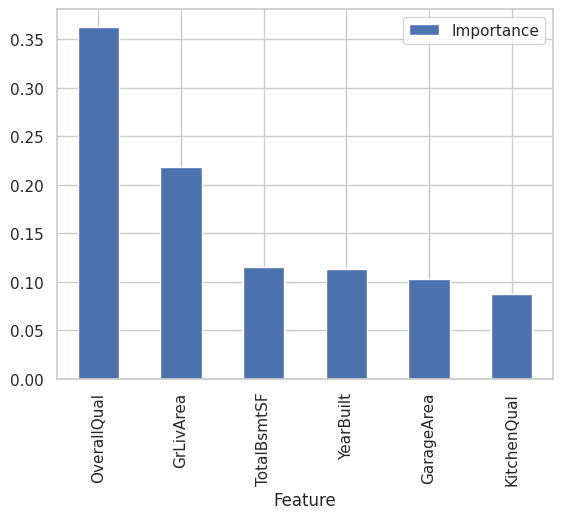

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(style='whitegrid')

data_cleaning_feat_eng_steps = 9

pipeline_steps = best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps]
temp_pipeline = Pipeline(pipeline_steps)

transformed_data = temp_pipeline.fit_transform(X_train)

def get_feature_names_from_pipeline(pipeline_steps, X_train):
    feature_names = X_train.columns  # Default to original feature names
    
    for name, transformer in pipeline_steps:
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names = transformer.get_feature_names_out()
    
    return feature_names

feature_names = get_feature_names_from_pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps], X_train)

transformed_data = pd.DataFrame(transformed_data, columns=feature_names)

if 'feat_selection' in best_regressor_pipeline.named_steps:
    feat_selector = best_regressor_pipeline['feat_selection']
    selected_columns = transformed_data.columns[feat_selector.get_support()]
else:
    selected_columns = transformed_data.columns

if hasattr(best_regressor_pipeline['model'], 'feature_importances_'):
    feature_importances = best_regressor_pipeline['model'].feature_importances_
else:
    print("Model does not have feature importances attribute. Skipping this step.")
    feature_importances = None

if feature_importances is not None:
    df_feature_importance = pd.DataFrame({
        'Feature': selected_columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print(f"* These are the {len(df_feature_importance)} most important features in descending order: \n{df_feature_importance['Feature'].to_list()}")

    df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
    plt.show()
else:
    print("No feature importance available to plot.")

Evaluates performance of a regression model by calculating and visualizing key metrics. regression_performance function evaluates model on both training and test sets, calling regression_evaluation to compute R² score, mean absolute error, mean squared error, and root mean squared error for each dataset. regression_evaluation_plots function generates scatter plots comparing actual values to predicted values for both training and test sets, overlaying a red line representing perfect predictions. Plots are saved as an image and displayed.

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X, y, pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', round(r2_score(y, prediction), 3))
  print('Mean Absolute Error:', round(mean_absolute_error(y, prediction), 3))
  print('Mean Squared Error:', round(mean_squared_error(y, prediction), 3))
  print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y, prediction)), 3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
  sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")
  plt.savefig(f'docs/plots/regression_performance.png', bbox_inches='tight')  
  plt.show()

Evaluates performance of the best regressor pipeline on both training and test sets.

Model Evaluation 

* Train Set
R2 Score: 1.0
Mean Absolute Error: 97.803
Mean Squared Error: 731865.551
Root Mean Squared Error: 855.491


* Test Set
R2 Score: 0.891
Mean Absolute Error: 18519.456
Mean Squared Error: 837433417.906
Root Mean Squared Error: 28938.442




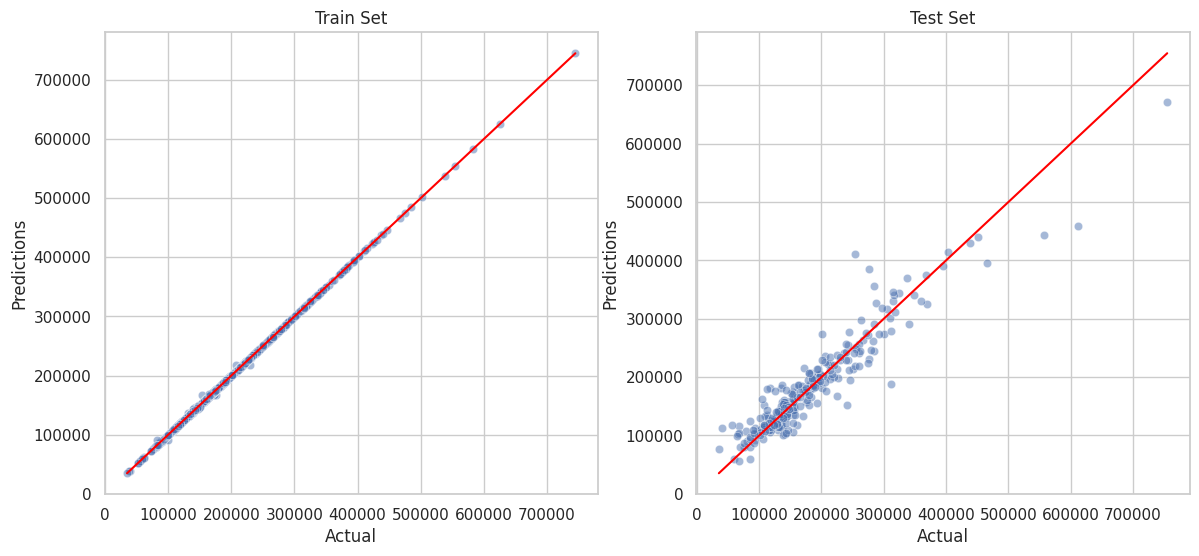

In [21]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Pipeline of the best regressor model.

In [22]:
best_regressor_pipeline

Pipeline(steps=[('drop',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageFinish', 'BsmtFinType1',
                                                'BsmtExposure',
                                                'GarageYrBlt'])),
                ('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'BedroomAbvGr'])),
                ('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'MasVnrArea'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(...
                            variables=['1stFlrSF', '2ndFlrSF', 'GarageArea',
                                       'LotArea', 'LotFrontage', 'MasVnrArea',
                                       'OpenPorchSF', 'TotalBsmtSF'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance')),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=42))),
                ('model', ExtraTreesRegressor(random_state=42))])

Creates a machine learning pipeline for regression that imputes missing values in the TotalBsmtSF feature with the mean, applies a log transformation to GrLivArea, a power transformation to TotalBsmtSF, the IQR method to cap extreme values in TotalBsmtSF and GarageArea, feature scaling with StandardScaler, and applies an ExtraTreesRegressor with hyperparameters.

In [23]:
def PipelineOptimization(model):
    pipeline_base = Pipeline(steps=[  
    ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['TotalBsmtSF']) ),
                                     
    ('lt', vt.LogTransformer(variables = ['GrLivArea']) ),

    ('pt', vt.PowerTransformer(variables = ['TotalBsmtSF']) ),
      
    ("Winsoriser_iqr",Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
                                                  variables=['TotalBsmtSF', 'GarageArea']) ),      

    ("feat_scaling", StandardScaler() ),

  ('model', ExtraTreesRegressor(max_depth=15, min_samples_split=50,
                                     n_estimators=150, random_state=42))])        
    return pipeline_base

Prints original column names in the df dataset.

In [24]:
print("Original columns in the dataset:", df.columns)

Original columns in the dataset: Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea',
       'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea',
       'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd',
       'SalePrice'],
      dtype='object')


Checks if columns in best_features are present in both X_train and X_test datasets. Identifies and prints any missing columns. If no columns are missing, filters both datasets to include only best_features and prints shapes and first 5 rows of X_train. Prints a message if any columns are missing.

In [25]:
best_features = ['OverallQual', 'GrLivArea', 'GarageArea', 'YearBuilt', 'TotalBsmtSF']

missing_train_columns = [col for col in best_features if col not in X_train.columns]
missing_test_columns = [col for col in best_features if col not in X_test.columns]

if missing_train_columns:
    print(f"Missing columns in X_train: {missing_train_columns}")

if missing_test_columns:
    print(f"Missing columns in X_test: {missing_test_columns}")

if not missing_train_columns and not missing_test_columns:
    X_train = X_train[best_features]
    X_test = X_test[best_features]

    print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)
    print(X_train.head(5))
else:
    print("Some columns are missing")

* Train set: (1168, 5) (1168,) 
* Test set: (292, 5) (292,)
      OverallQual  GrLivArea  GarageArea  YearBuilt  TotalBsmtSF
254             5       1314         294       1957         1314
1066            6       1571         380       1993          799
638             5        796           0       1910          796
799             5       1768         240       1937          731
380             5       1691         308       1924         1026


Dictionary containing a model selection.

In [26]:
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=42)}

Dictionary containing a parameter selection.

In [27]:
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

Defines a set of hyperparameters for tuning an ExtraTreesRegressor model.

In [28]:
params_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [3, 5, 10],
        'model__min_samples_split': [5, 10, 20],
        'model__min_samples_leaf': [5, 10, 20],
    },
}

Performs hyperparameter optimization using HyperparameterOptimizationSearch with models (models_search) and hyperparameters (params_search). Fit method trains the model on X_train and y_train with 5-fold cross-validation (cv=5), evaluating performance using R² scoring (scoring='r2'). Utilizes all available CPU cores (n_jobs=-1) for parallel computation, aiming to find the best hyperparameter combination for ExtraTreesRegressor.

In [29]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 81 candidates, totalling 405 fits


Retrieves a summary of the grid search results using the score_summary method from the search object, sorting the results by the mean score.

In [30]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
59,ExtraTreesRegressor,0.7584,0.806488,0.842669,0.03204,10,5,10,150
56,ExtraTreesRegressor,0.7584,0.806488,0.842669,0.03204,10,5,5,150
58,ExtraTreesRegressor,0.757928,0.80629,0.842818,0.031851,10,5,10,100
55,ExtraTreesRegressor,0.757928,0.80629,0.842818,0.031851,10,5,5,100
57,ExtraTreesRegressor,0.757305,0.805861,0.839844,0.031077,10,5,10,50
...,...,...,...,...,...,...,...,...,...
23,ExtraTreesRegressor,0.675743,0.725611,0.751709,0.026394,3,20,10,150
26,ExtraTreesRegressor,0.675743,0.725611,0.751709,0.026394,3,20,20,150
21,ExtraTreesRegressor,0.673393,0.725395,0.756129,0.028222,3,20,10,50
24,ExtraTreesRegressor,0.673393,0.725395,0.756129,0.028222,3,20,20,50


Selects best model from grid_search_summary DataFrame by accessing the first row and first column, which corresponds to the model with the highest mean score.

In [31]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Retrieves the best regressor pipeline from grid_search_pipelines using the best model identifier.

In [32]:
best_pipeline_regressor = grid_search_pipelines[best_model].best_estimator_
best_pipeline_regressor

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['TotalBsmtSF'])),
                ('lt', LogTransformer(variables=['GrLivArea'])),
                ('pt', PowerTransformer(variables=['TotalBsmtSF'])),
                ('Winsoriser_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['TotalBsmtSF', 'GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, min_samples_leaf=5,
                                     min_samples_split=5, n_estimators=150,
                                     random_state=42))])

Attempts to create a directory structure for saving a machine learning pipeline, defining a path (file_path) for version 'v1' under outputs/ml_pipeline/predict_price/. Uses os.makedirs to create the directory and prints any exception messages if an error occurs.

In [33]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_price/v1'


Displays the first 10 rows of the X_train dataset.

In [34]:
X_train.head(10)

,OverallQual,GrLivArea,GarageArea,YearBuilt,TotalBsmtSF
254,5,1314,294,1957,1314
1066,6,1571,380,1993,799
638,5,796,0,1910,796
799,5,1768,240,1937,731
380,5,1691,308,1924,1026
303,5,894,552,1972,894
86,6,1560,400,2005,684
1385,4,1154,240,1922,796
265,6,1422,576,1981,1422
793,8,1496,474,2007,1496


Saves the X_train and y_train datasets as CSV files in the specified directory (file_path). The X_train data is saved as X_train.csv and the y_train data as y_train.csv, both without including row indices.

In [35]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

Displays the first 10 rows of the y_test dataset.

In [36]:
y_test.head(10)

892     154500
1105    325000
413     115000
522     159000
1036    315500
614      75500
218     311500
1160    146000
649      84500
887     135500
Name: SalePrice, dtype: int64

Saves the X_test and y_test datasets as CSV files in the specified directory (file_path). The X_test data is saved as X_test.csv and the y_test data as y_test.csv, both without including row indices.

In [37]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False) 
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

Show the steps within the pipeline.

In [38]:
best_pipeline_regressor

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['TotalBsmtSF'])),
                ('lt', LogTransformer(variables=['GrLivArea'])),
                ('pt', PowerTransformer(variables=['TotalBsmtSF'])),
                ('Winsoriser_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['TotalBsmtSF', 'GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, min_samples_leaf=5,
                                     min_samples_split=5, n_estimators=150,
                                     random_state=42))])

Prints the machine learning pipeline preprocessing and modeling steps.

In [39]:
print(best_pipeline_regressor)

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['TotalBsmtSF'])),
                ('lt', LogTransformer(variables=['GrLivArea'])),
                ('pt', PowerTransformer(variables=['TotalBsmtSF'])),
                ('Winsoriser_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['TotalBsmtSF', 'GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, min_samples_leaf=5,
                                     min_samples_split=5, n_estimators=150,
                                     random_state=42))])


Saves best_pipeline_regressor to a file using joblib. It serializes the pipeline object and stores it as regression_pipeline.pkl in a directory defined by file_path.

In [40]:
import joblib
joblib.dump(value=best_pipeline_regressor, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/predict_price/v1/regression_pipeline.pkl']

Creates a bar plot to visualize the feature importance of a machine learning model using the data stored in df_feature_importance.

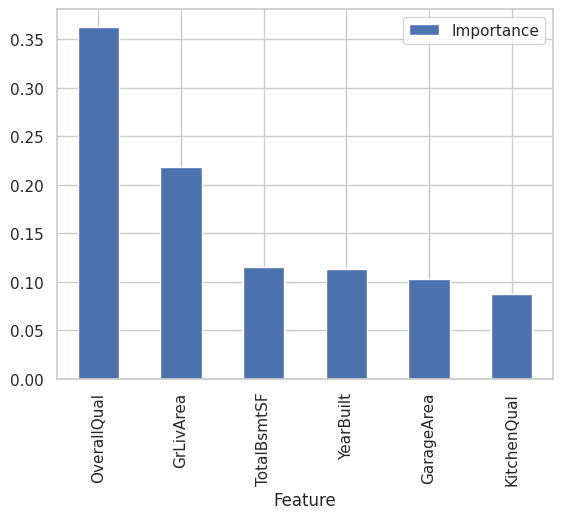

In [41]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

Creates a bar plot for feature importance and saves it as images in two specified locations.

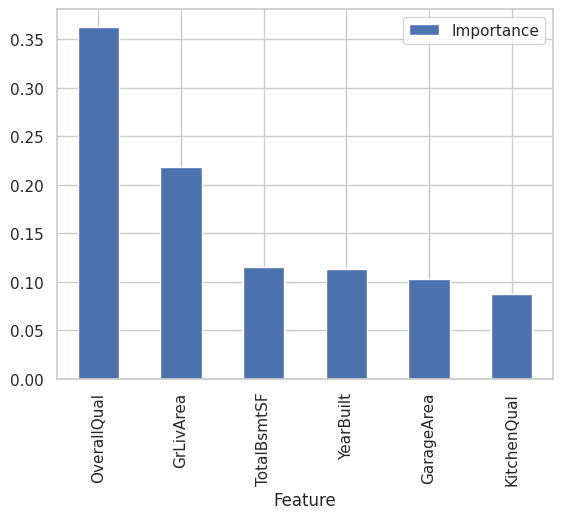

In [42]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')
plt.savefig(f'docs/plots/features_importance.png', bbox_inches='tight') 

Prints the machine learning pipeline preprocessing and modeling steps.

In [43]:
print(best_pipeline_regressor)

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['TotalBsmtSF'])),
                ('lt', LogTransformer(variables=['GrLivArea'])),
                ('pt', PowerTransformer(variables=['TotalBsmtSF'])),
                ('Winsoriser_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['TotalBsmtSF', 'GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, min_samples_leaf=5,
                                     min_samples_split=5, n_estimators=150,
                                     random_state=42))])


## Conclusions and Next Steps

The regression pipeline is now complete.

The Next steps are to deploy it.